<a href="https://colab.research.google.com/github/asafuM-56/forest_fire_prediction/blob/main/Forest_fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pre-processing:                                                 
Missing Data, Outliers, Heatmap, Determine what model to use

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import math
import pickle

#Load the dataset
file_path = '/content/wildfire_prediction_multi_output_dataset_v2.xlsx'

# Read the Excel file into a Pandas DataFrame
df = pd.read_excel(file_path)

print(df.head())  # Print the first few rows of the DataFrame

   Temperature (°C)  Humidity (%)  Wind Speed (km/h)  Rainfall (mm)  \
0         27.733250     89.108222          13.165364      44.032705   
1         28.789452     21.543283          37.853201      42.478192   
2         30.256666     72.335215          19.592377      12.104919   
3         17.856476     84.138818           5.448178            NaN   
4         34.260178     62.698878          13.356131      27.465001   

   Fuel Moisture (%) Vegetation Type  Slope (%) Region  Fire Size (hectares)  \
0          16.072075       Grassland  59.615524  South            442.648940   
1          25.176666          Forest  26.995937  South             17.689832   
2          22.251979       Shrubland  55.623107  South            256.142917   
3          20.820927          Forest   3.944492   East            165.111292   
4           6.842731       Shrubland  54.280029   West            160.298123   

   Fire Duration (hours)  Suppression Cost ($) Fire Occurrence  
0              11.616707   

Data Types classification

In [2]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns

print("\nNumeric columns:", numeric_cols)
print("\nCategorical columns:", categorical_cols)


Numeric columns: Index(['Temperature (°C)', 'Humidity (%)', 'Wind Speed (km/h)',
       'Rainfall (mm)', 'Fuel Moisture (%)', 'Slope (%)',
       'Fire Size (hectares)', 'Fire Duration (hours)',
       'Suppression Cost ($)'],
      dtype='object')

Categorical columns: Index(['Vegetation Type', 'Region', 'Fire Occurrence'], dtype='object')


Missing Data

In [3]:
#Check for missing data
print(df.isna().sum())

#Check for the number of rows and column
num_rows, num_cols = df.shape

print('Number of Rows = ', num_rows)
print('Number of Columns = ', num_cols)

Temperature (°C)         247
Humidity (%)             250
Wind Speed (km/h)        250
Rainfall (mm)            250
Fuel Moisture (%)        250
Vegetation Type            0
Slope (%)                  0
Region                     0
Fire Size (hectares)     244
Fire Duration (hours)    250
Suppression Cost ($)     250
Fire Occurrence            0
dtype: int64
Number of Rows =  5000
Number of Columns =  12


Will fill the missing data with the mean

In [4]:
# Replace missing values in numeric columns with the mean
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

#Make sure it is filled
print(df.isna().sum())

Temperature (°C)         0
Humidity (%)             0
Wind Speed (km/h)        0
Rainfall (mm)            0
Fuel Moisture (%)        0
Vegetation Type          0
Slope (%)                0
Region                   0
Fire Size (hectares)     0
Fire Duration (hours)    0
Suppression Cost ($)     0
Fire Occurrence          0
dtype: int64


Handling Outliers

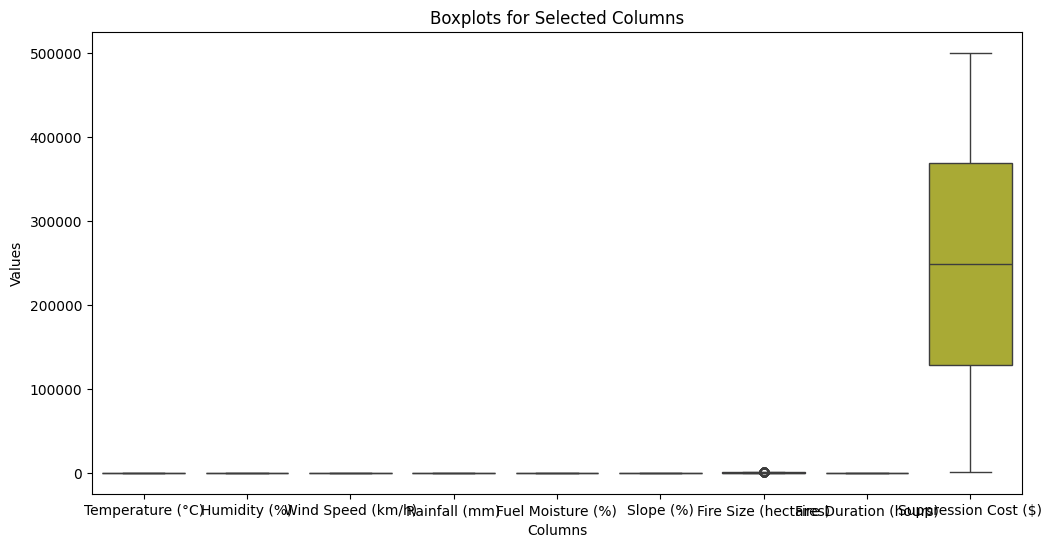

Outliers detected in the following columns:
Temperature (°C)           0
Humidity (%)               0
Wind Speed (km/h)          0
Rainfall (mm)              0
Fuel Moisture (%)          0
Slope (%)                  0
Fire Size (hectares)     100
Fire Duration (hours)      0
Suppression Cost ($)       0
dtype: int64


In [5]:
#Looking for outliers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the interquartile range (IQR) for each column
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier threshold
outlier_threshold = 1.5 * IQR

# Identify outliers
outliers = (df[numeric_cols] < (Q1 - outlier_threshold)) | (df[numeric_cols] > (Q3 + outlier_threshold))

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create the boxplot
sns.boxplot(data=df[numeric_cols], ax=ax)

# Set labels and title
ax.set_title('Boxplots for Selected Columns')
ax.set_xlabel('Columns')
ax.set_ylabel('Values')

plt.show()

# Check if outliers exist
if outliers.any().any():
    print("Outliers detected in the following columns:")
    print(outliers.sum())
else:
    print("No outliers detected.")

Dropping rows with outliers

In [6]:
# Calculate the interquartile range (IQR) for each column
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier threshold
outlier_threshold = 2 * IQR

# Identify outliers
outliers = (df[numeric_cols] < (Q1 - outlier_threshold)) | (df[numeric_cols] > (Q3 + outlier_threshold))

# Drop rows containing outliers
df = df[~outliers.any(axis=1)]

#Re-identifying the outliers for display purposes
outliers = (df[numeric_cols] < (Q1 - outlier_threshold)) | (df[numeric_cols] > (Q3 + outlier_threshold))

# Check if outliers exist
if outliers.any().any():
    print("Outliers detected in the following columns:")
    print(outliers.sum())
else:
    print("No outliers detected.")

No outliers detected.


Check for duplicates

In [7]:
# Check for duplicates in the entire dataset
duplicates = df.duplicated()
# If there are any duplicates, the 'duplicates' variable will contain True for those rows
if duplicates.any():
    # Get the rows with duplicates
    duplicate_rows = df[duplicates]
else:
    print("No duplicates found in the dataset.")

No duplicates found in the dataset.


Showing correlations with a heatmap

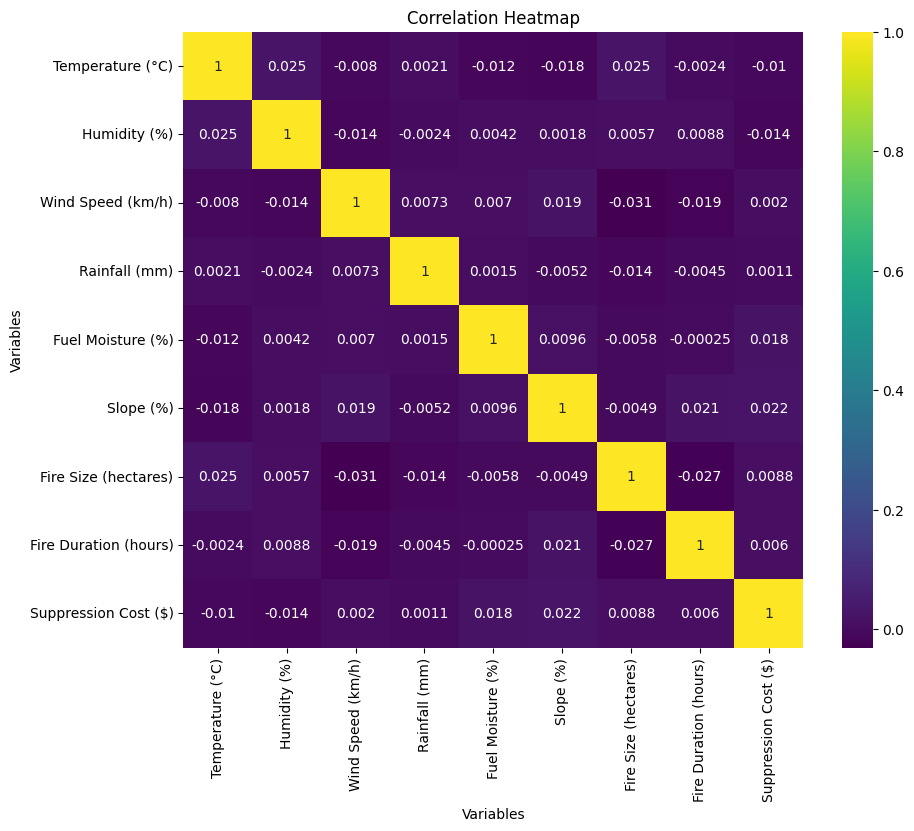

In [8]:
#Redefining numeric columns since I get an error if I don't
numeric_cols = df.select_dtypes(include=['float64', 'int64'])

#Make the correlation matrix
correlation_matrix = numeric_cols.corr()

#Making the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap="viridis")

# Set the title and labels
plt.title("Correlation Heatmap")
plt.xlabel("Variables")
plt.ylabel("Variables")

# Show the plot
plt.show()

None of the numerical vatriables ares highly correlated, so none of the data is redundant

Encoding the target variable

In [10]:
label_encoder = LabelEncoder()

# Apply label encoding to the target column (Fire Occurrence)
df['Fire Occurrence'] = label_encoder.fit_transform(df['Fire Occurrence'])

# Save the label encoder for future use
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

Encoding the categorical features

In [13]:
df_encoded = pd.get_dummies(df, columns=['Vegetation Type', 'Region'], drop_first=True)
print(df_encoded.head())

   Temperature (°C)  Humidity (%)  Wind Speed (km/h)  Rainfall (mm)  \
0         27.733250     89.108222          13.165364      44.032705   
1         28.789452     21.543283          37.853201      42.478192   
2         30.256666     72.335215          19.592377      12.104919   
3         17.856476     84.138818           5.448178      25.295303   
4         34.260178     62.698878          13.356131      27.465001   

   Fuel Moisture (%)  Slope (%)  Fire Size (hectares)  Fire Duration (hours)  \
0          16.072075  59.615524            442.648940              11.616707   
1          25.176666  26.995937             17.689832               6.011346   
2          22.251979  55.623107            256.142917             117.204594   
3          20.820927   3.944492            165.111292              38.125806   
4           6.842731  54.280029            160.298123              15.668068   

   Suppression Cost ($)  Fire Occurrence  Vegetation Type_Grassland  \
0         491412.1681

Training and testing the models

In [14]:
# Splitting the dataset into training and test sets
X = df_encoded.drop('Fire Occurrence', axis=1)
y = df_encoded['Fire Occurrence']

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data (for certain models like SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Machine Learning Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

# Training and evaluating the models
best_model = None
best_rmse = float('inf')

for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Use scaled data for SVM, for others, use non-scaled data
    if model_name == "SVM":
        model.fit(X_train_scaled, y_train)
        y_test_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)

    # Calculate RMSE for the test dataset
    rmse_test = math.sqrt(mean_squared_error(y_test, y_test_pred))

    # Save the best model based on RMSE for the test dataset
    if rmse_test < best_rmse:
        best_rmse = rmse_test
        best_model = model
        best_model_name = model_name

    print(f"{model_name} RMSE on Test Data: {rmse_test}")

# Save the best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"Best model: {best_model_name} with RMSE: {best_rmse}")

Training Random Forest...
Random Forest RMSE on Test Data: 0.5505099676570769
Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression RMSE on Test Data: 0.5449208892217329
Training Decision Tree...
Decision Tree RMSE on Test Data: 0.6428571428571429
Training SVM...
SVM RMSE on Test Data: 0.5449208892217329
Best model: Logistic Regression with RMSE: 0.5449208892217329
